In [1]:
import pathlib
import os

In [2]:
data_path = str(pathlib.Path(os.getcwd()).parent / "src" / "data" / "corpus.txt")

In [3]:
with open(data_path, "r") as f:
    corpus = f.read()

In [4]:
# Get rid of the corpus header
import regex

exerpt, book = regex.split(
    r"\s*\*\*\* START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET \*\*\*\s*", corpus
)
book, post_story_notice = regex.split(
    r"\s\*\*\* END OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET *\*\*\s*", corpus
)

In [5]:
print(book)

The Project Gutenberg eBook of Romeo and Juliet
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Romeo and Juliet

Author: William Shakespeare

Release date: November 1, 1998 [eBook #1513]
                Most recently updated: June 27, 2023

Language: English

Credits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers


*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***




THE TRAGEDY OF ROMEO AND JULIET

by William Shakespeare




Contents

THE PROLOGUE.

ACT I
Scene I. A public place.
Scene II. A Street.
Scene III. Room in Capulet’s House.
Scene

In [6]:
epilogue_descriptions, book_text = regex.split(
    r"Scene III. A churchyard; in it a Monument belonging to the Capulets.", book
)

In [17]:
import re


def roman_to_int(s):
    roman_numerals = {"I": 1, "V": 5, "X": 10, "L": 50, "C": 100, "D": 500, "M": 1000}
    int_val = 0
    for i in range(len(s)):
        if i > 0 and roman_numerals[s[i]] > roman_numerals[s[i - 1]]:
            int_val += roman_numerals[s[i]] - 2 * roman_numerals[s[i - 1]]
        else:
            int_val += roman_numerals[s[i]]
    return int_val

In [18]:
def split_into_chapters(text):
    # Split text into acts
    acts = re.split(r"(?=ACT\s+[IVXLCDM]+)", text)
    acts = [act for act in acts if act.strip().startswith("ACT")]

    act_scene_data = []

    # Regex to capture scenes more reliably
    scene_regex = r"\bSCENE\s+[IVXLCDM]+\b"

    for act in acts:
        act_number_match = re.search(r"ACT\s+([IVXLCDM]+)", act)
        if act_number_match:
            current_act_number = roman_to_int(act_number_match.group(1))
            scenes = re.split(scene_regex, act[act_number_match.end() :])
            scenes = [scene.strip() for scene in scenes if scene.strip()]

            # Find scene numbers by re-applying the scene regex to capture the numbers
            scene_numbers = re.findall(scene_regex, act)
            scene_numbers = [roman_to_int(num.split()[-1]) for num in scene_numbers]

            for scene_number, scene_text in zip(scene_numbers, scenes):
                act_scene_data.append(
                    {
                        "act": current_act_number,
                        "scene": scene_number,
                        "text": scene_text,
                    }
                )

    return act_scene_data

In [19]:
chapters_data = split_into_chapters(book_text)

In [20]:
# Example: converting to a DataFrame
import pandas as pd

df = pd.DataFrame(chapters_data)

/var/folders/fp/t9rgk32d3b53vh9059kcnmwr0000gp/T/ipykernel_27199/2004175486.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['scene_length'])


<Axes: xlabel='scene_length', ylabel='Density'>

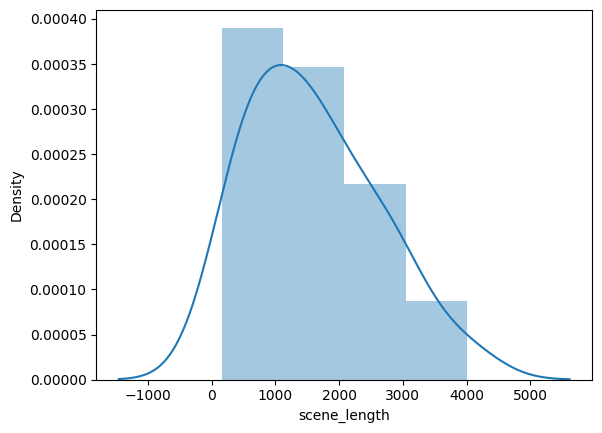

In [52]:
# Next some EDA
# Find the number of tokens in average scene.
import tiktoken
import tqdm
import seaborn as sns

tqdm.tqdm.pandas()

enc = tiktoken.get_encoding("cl100k_base")

df["scene_length"] = df["text"].apply(lambda x: len(enc.encode(x)))
sns.distplot(df["scene_length"])

/var/folders/fp/t9rgk32d3b53vh9059kcnmwr0000gp/T/ipykernel_27199/4057851936.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['scene_length'])


<Axes: xlabel='scene_length', ylabel='Density'>

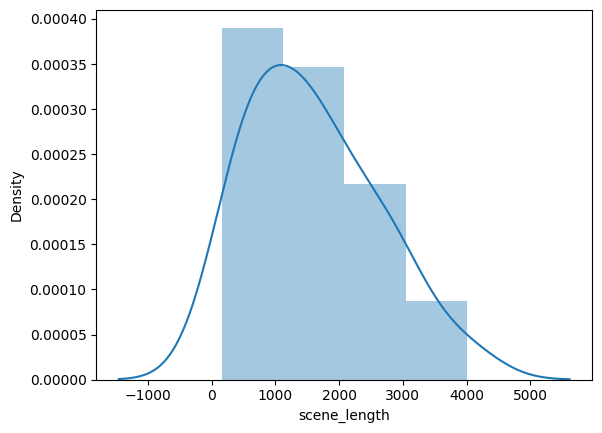

In [53]:
import pandas as pd
import re


def extract_blocks(df):
    # Define the pattern to split by
    pattern = r"\[\_.*?\_\]"

    # Function to apply to each row
    def split_into_blocks(row):
        # Find all segments split by the pattern
        segments = re.split(pattern, row["text"])
        segments = [seg.strip() for seg in segments if seg.strip()]

        # Find all instances of the pattern
        dividers = re.findall(pattern, row["text"])

        # Combine dividers with text segments
        combined = []
        for seg, div in zip(
            segments, dividers + [""]
        ):  # Add empty string to handle last segment without a following divider
            combined.append(f"{seg} {div}".strip())

        return combined

    # Create a new column 'blocks' in the DataFrame by applying the function
    df["blocks"] = df.apply(split_into_blocks, axis=1)

    # Explode the DataFrame on the 'blocks' column to separate each block into its own row
    exploded_df = df.explode("blocks").reset_index(drop=True)

    # Optionally, clean up by removing the original text column if no longer needed
    # exploded_df.drop('text', axis=1, inplace=True)

    return exploded_df

In [54]:
expanded_df = extract_blocks(df)

100%|██████████| 121/121 [00:00<00:00, 3684.21it/s]
/var/folders/fp/t9rgk32d3b53vh9059kcnmwr0000gp/T/ipykernel_27199/1220141596.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expanded_df['block_length'])


<Axes: xlabel='block_length', ylabel='Density'>

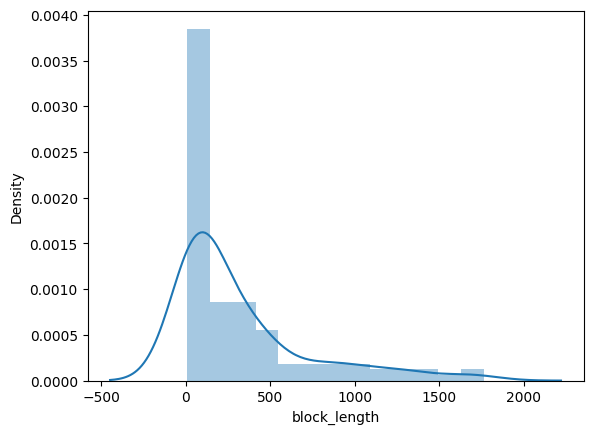

In [55]:
expanded_df["block_length"] = expanded_df["blocks"].progress_apply(
    lambda x: len(enc.encode(x))
)
sns.distplot(expanded_df["block_length"])

In [70]:
act_text_length = (
    expanded_df.groupby("act")["scene_length"].sum().reset_index(name="act_length")
)

# Merge the aggregated data back into the original DataFrame
expanded_df = expanded_df.merge(act_text_length, on="act")

In [75]:
expanded_df = expanded_df.head(10)

In [76]:
# Initialize the Hugging Face NER pipeline
from transformers import pipeline

ner_pipeline = pipeline(
    "ner",
    model="Davlan/distilbert-base-multilingual-cased-ner-hrl",
    grouped_entities=True,
)

/Users/Charlie/Library/Caches/pypoetry/virtualenvs/gpt-er-proof-of-concept-P6GpO3tj-py3.11/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [82]:
type(ner_pipeline)

transformers.pipelines.token_classification.TokenClassificationPipeline

In [77]:
# Function to apply NER to each row and extract people
def extract_people(text: str):
    ner_results = ner_pipeline(text)
    people = [
        entity["word"] for entity in ner_results if entity["entity_group"] == "PER"
    ]
    return list(set(people))


# Apply the function to each row in the 'text' column
expanded_df["people"] = expanded_df["text"].progress_apply(extract_people)

100%|██████████| 10/10 [00:01<00:00,  8.13it/s]
/var/folders/fp/t9rgk32d3b53vh9059kcnmwr0000gp/T/ipykernel_27199/1942948299.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expanded_df['people'] = expanded_df['text'].progress_apply(extract_people)


In [89]:
[dict(v) for _, v in df.iterrows()]

[{'act': 1,
  'scene': 1,
  'text': '. A public place.\n\n\n Enter Sampson and Gregory armed with swords and bucklers.\n\nSAMPSON.\nGregory, on my word, we’ll not carry coals.\n\nGREGORY.\nNo, for then we should be colliers.\n\nSAMPSON.\nI mean, if we be in choler, we’ll draw.\n\nGREGORY.\nAy, while you live, draw your neck out o’ the collar.\n\nSAMPSON.\nI strike quickly, being moved.\n\nGREGORY.\nBut thou art not quickly moved to strike.\n\nSAMPSON.\nA dog of the house of Montague moves me.\n\nGREGORY.\nTo move is to stir; and to be valiant is to stand: therefore, if thou\nart moved, thou runn’st away.\n\nSAMPSON.\nA dog of that house shall move me to stand.\nI will take the wall of any man or maid of Montague’s.\n\nGREGORY.\nThat shows thee a weak slave, for the weakest goes to the wall.\n\nSAMPSON.\nTrue, and therefore women, being the weaker vessels, are ever thrust to\nthe wall: therefore I will push Montague’s men from the wall, and\nthrust his maids to the wall.\n\nGREGORY.\nTh

In [81]:
!black *

Skipping .ipynb files as Jupyter dependencies are not installed.
You can fix this by running ``pip install "black[jupyter]"``
No Python files are present to be formatted. Nothing to do 😴
